**Purpose:** To perform Exploratory Data Analysis of a *single Lightcurve*, **Kepler-10 b**, containing Exoplanet signals in order to inform preprocessing steps necessary for building an ML Model that would be able predict the presence of an Exoplanet and/or predict its Orbital Period

**Goals:**

1. Understand the distribution of Flux Observations, and the presence of outliers.  
2. Decompose the Lightcurve into Trend, Seasonality, and Residuals

3. Isolate transit signals by identifying and removing Outliers, Trend, and Seasonality and then fold the residual on the period with the highest power in the frequency domain

**Input:** Lightcurve  of Exoplanet **Kepler-10 b**, obtained via API with observations of 4 consecutive quarters.




In [8]:
!pip uninstall numpy
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-

In [1]:
import numpy as np
print("NumPy version:", np.__version__)

NumPy version: 1.26.4


In [3]:
!pip install "numpy<2" astropy lightkurve scikit-learn --upgrade --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 144.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 103.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cu

In [36]:
import numpy as np
#import batman
import lightkurve as lk
import astropy
from astropy.table import Table
#import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightkurve import search_lightcurve, SearchResult
from lightkurve.periodogram import LombScarglePeriodogram
import warnings
import re
from statsmodels.tsa.seasonal import STL

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Lightkurve version:", lk.__version__)
#print("Astropy version:", astropy.__version__)
print("Seaborn version:", sns.__version__)

Pandas version: 2.2.2
NumPy version: 1.26.4
Lightkurve version: 2.5.1
Seaborn version: 0.13.2


In [3]:
#############################
# Load Kepler 10-b Lightcurve
#############################
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress lightkurve warnings

# Set Seaborn style for consistent aesthetics
sns.set(style="whitegrid", palette="muted", context="talk")

# Step 0: Load a Kepler lightcurve (e.g., Kepler-10, a known exoplanet host)
target = "Kepler-10 b"
desired_quarters = [1, 2, 3, 4]  # Quarters 1-4
search_result = search_lightcurve(target, mission="Kepler", cadence="long", quarter=desired_quarters)

# Filter entries where the 'mission' field matches "Kepler Quarter 01" through "Kepler Quarter 04"
valid_indices = [
    i for i, mission in enumerate(search_result.table['mission'])
    if re.fullmatch(r"Kepler Quarter 0[1-4]", str(mission).strip())
]

# Construct a new SearchResult with only valid entries
from astropy.table import Table
filtered_table = search_result.table[valid_indices]
filtered_search_result = SearchResult(filtered_table)


lc_collection = filtered_search_result.download_all()
#lc = lc_search.download()
lc = lc_collection.stitch()
print(f"Loaded lightcurve for {target} with {len(lc)} points.")


Loaded lightcurve for Kepler-10 b with 10852 points.


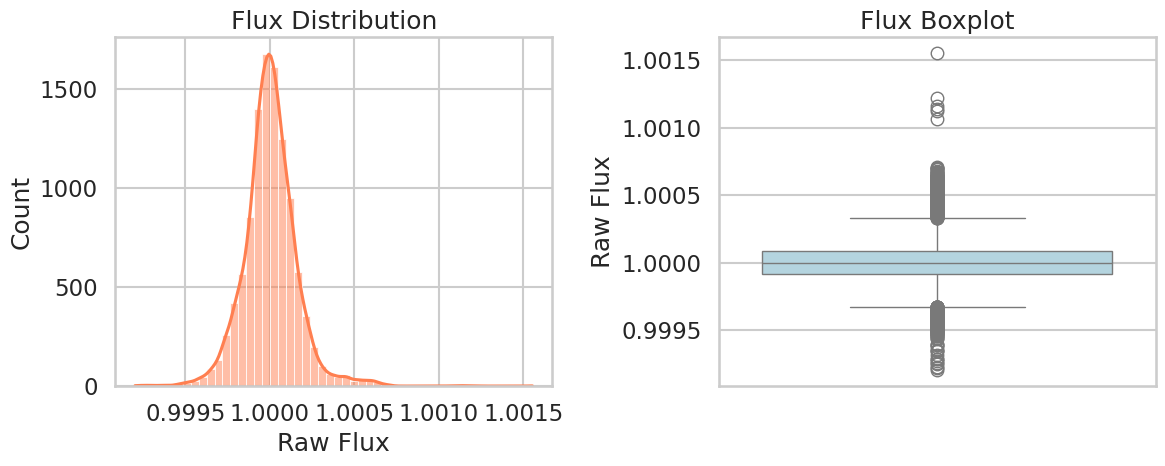

In [6]:
#############################################
#  Raw Flux Distribution Analysis
# Visualization: Seaborn histogram and boxplot
#############################################
flux_df = pd.DataFrame({"Flux": lc.flux})
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data=flux_df, x="Flux", bins=50, color="coral", kde=True)
plt.title("Flux Distribution")
plt.xlabel("Raw Flux")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=flux_df, y="Flux", color="lightblue")
plt.title("Flux Boxplot")
plt.ylabel("Raw Flux")

plt.tight_layout()
plt.show()
#plt.savefig(os.path.join(output_dir, "flux_distribution.png"))
#plt.close()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

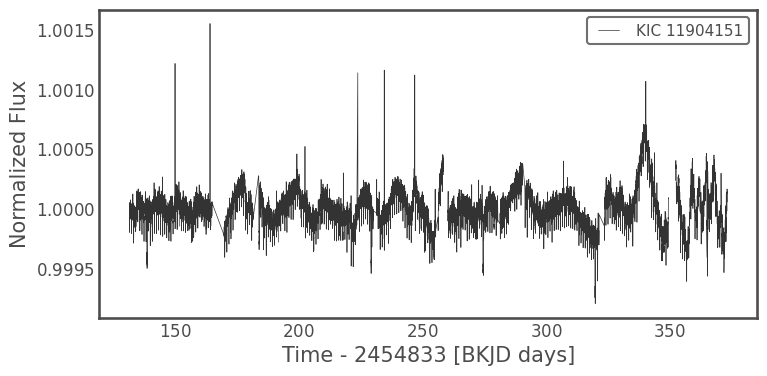

In [7]:
lc.plot()

Found 12 data gaps out of 10852 points, (0.11%)  using a threshold of 0.0205.


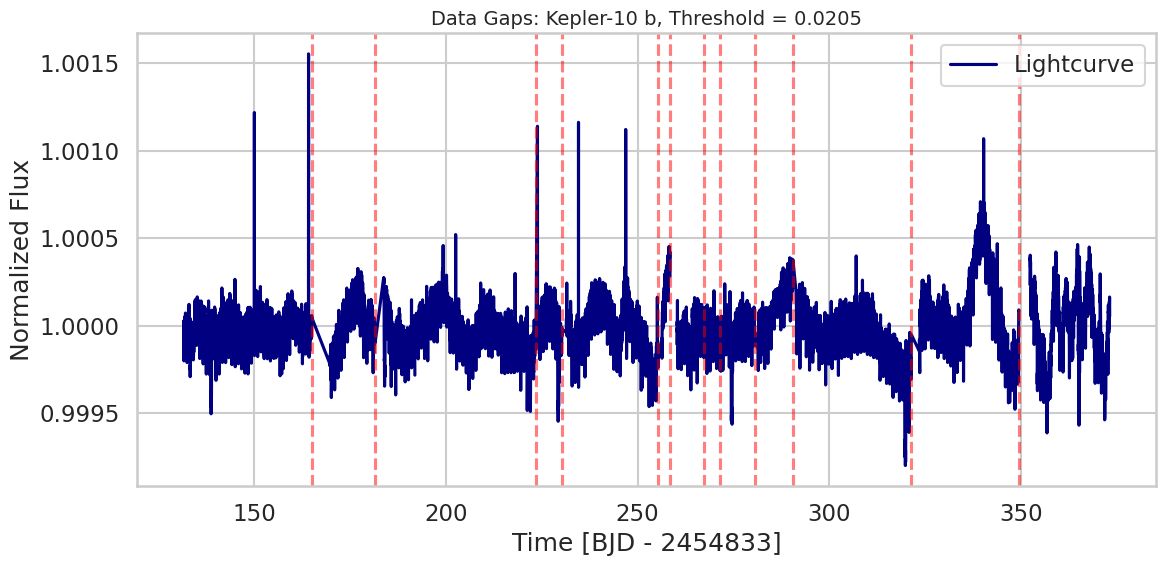

In [49]:
##############################################
# Visualize gaps in the time dimension
# (i.e. observations at irregular cadence, higher than 0.0204)
###############################################
plot_gaps(lc, 0.0205)

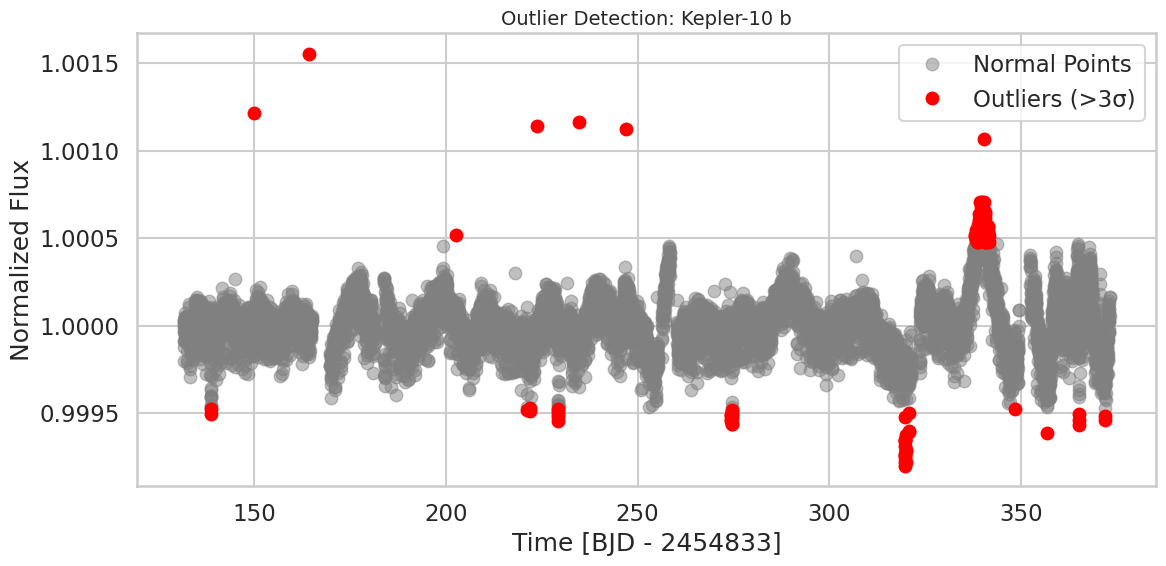

In [38]:
##############################
# Visualize FLUX Outliers
##############################

# Visualization: Seaborn scatter with outlier highlights
flux_mean = np.mean(lc.flux)
flux_std = np.std(lc.flux)
outlier_mask = np.abs(lc.flux - flux_mean) > 3 * flux_std
outliers = lc[outlier_mask]
normal = lc[~outlier_mask]

plt.figure(figsize=(12, 6))
plt.plot(normal.time.value, normal.flux, "o", color="gray", alpha=0.5, label="Normal Points")
plt.plot(outliers.time.value, outliers.flux, "o", color="red", label="Outliers (>3σ)")
plt.title(f"Outlier Detection: {target}", fontsize=14)
plt.xlabel("Time [BJD - 2454833]")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()
plt.show()


**TAKEAWAY:**
1. Histogram showsFlux Distribution is NORMALLY Distributed,
2. From the plot of the Lightcurve, Outliers definitey exist, and are more extreme on the high side than the low side
3. Likewise,Low Frequency periodic behavior is seen, indicating Stellar Variability which will need to be removed
4. There are gaps at certain intervals, suggesting the need to interpolation or fill with gaussian noise, etc.
5. Finally, the plot also shows high frequency dips in the flux value, which may very well be the Transit Signal we are hoping to Isolate

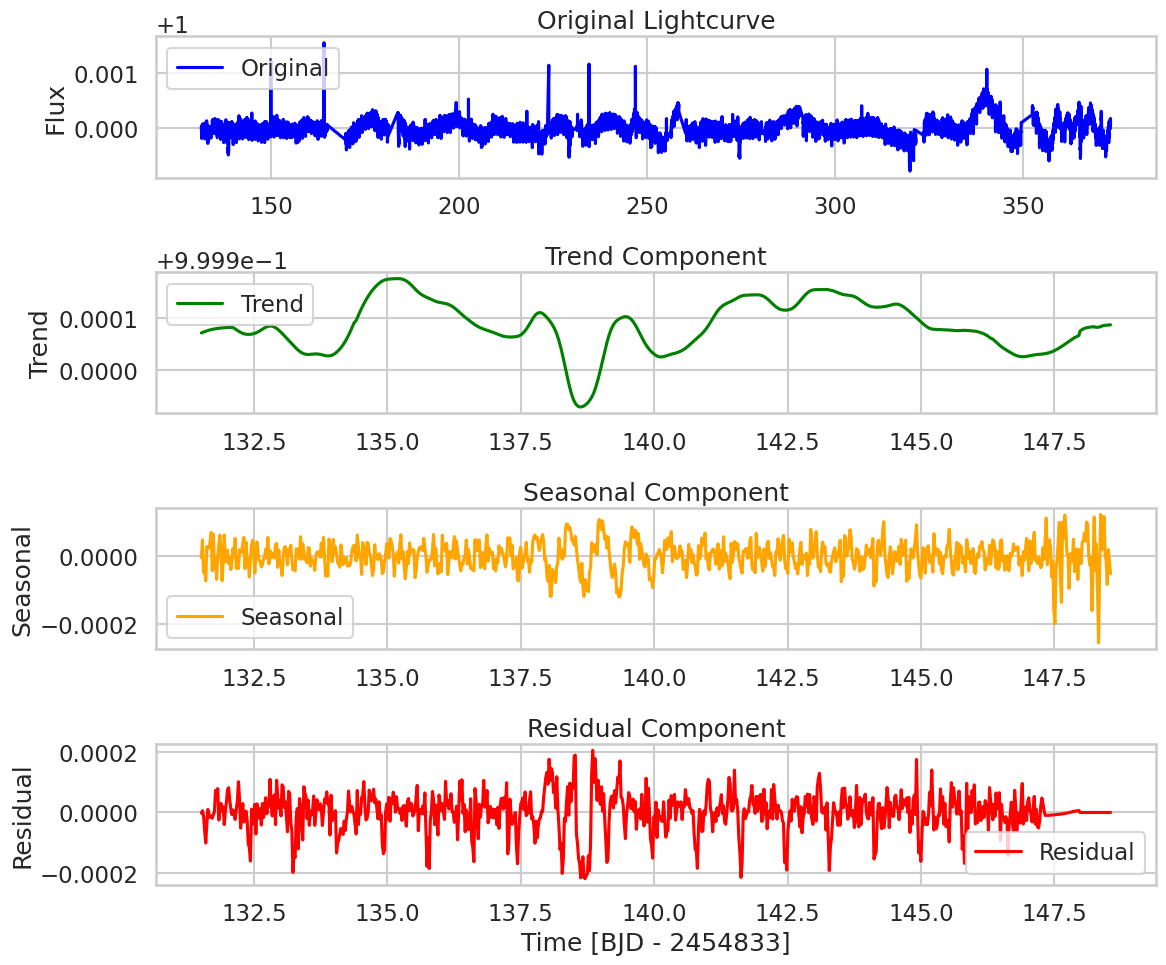

In [37]:
#################################################
# Decompose and Visualize Lightcurve's
# Trend,  Seasonality, and Residuals
#################################################

# Visualization: Seaborn line plots for STL components
# Convert lightcurve to pandas for STL
ts_df = pd.DataFrame({"flux": lc.flux}, index=lc.time.value)
stl = STL(ts_df["flux"], period=30, seasonal=7).fit()  # Approximate period for decomposition

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
sns.lineplot(x=ts_df.index, y=ts_df["flux"], color="blue", label="Original")
plt.title("Original Kepler 10-b Lightcurve")
plt.xlabel("")
plt.ylabel("Flux")

plt.subplot(4, 1, 2)
sns.lineplot(x=ts_df.index, y=stl.trend, color="green", label="Trend")
plt.title("Trend Component")
plt.xlabel("")
plt.ylabel("Trend")

plt.subplot(4, 1, 3)
sns.lineplot(x=ts_df.index, y=stl.seasonal, color="orange", label="Seasonal")
plt.title("Seasonal Component")
plt.xlabel("")
plt.ylabel("Seasonal")

plt.subplot(4, 1, 4)
sns.lineplot(x=ts_df.index, y=stl.resid, color="red", label="Residual")
plt.title("Residual Component")
plt.xlabel("Time [BJD - 2454833]")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()
#plt.savefig(os.path.join(output_dir, "stl_decomposition.png"))
#plt.close()


In [29]:
###########################
# PREPROCESS the Lightcurve
############################

print(f'lc original length: {len(lc)}')

# Step 1. Remove bad quality observations
lc_quality=  lc[lc['quality']==0]
print(f'lc quality length: {len(lc_quality)}')
print(f'Quality %: {100.0*len(lc_quality)/len(lc)}')

# Step 2: Remove non-numeric data
lc_no_NaNs =lc_quality.remove_nans()
print(f'lc no nans length: {len(lc_no_NaNs)}')
# Step 3: Flatten
lc_flattened = lc_no_NaNs.flatten(window_length=401, sigma=3)
print(f'lc flattened length: {len(flattened_lc)}')

# Step 4: Remove Flux Outliers by sigma-clipping
lc_3sigma = lc_flattened.remove_outliers(sigma=3)
print(f'lc 3sigma length: {len(lc_3sigma)}')

# Step 5: Normalize
lc_norm =lc_3sigma.normalize().remove_nans()
print(f'lc normalized length: {len(lc_norm)}')

# Step 6: Fill time Gaps in the light curve with Gaussian noise appropriate to the Lightcurves Signal to Noise Ratio
lc_filled=lc_flattened.fill_gaps()
print(f'lc filled length: {len(lc_filled)}')

lc original length: 10852
lc quality length: 9388
Quality %: 86.50939918908956
lc no nans length: 9386
lc flattened length: 9386
lc 3sigma length: 9188
lc normalized length: 9188
lc filled length: 11830


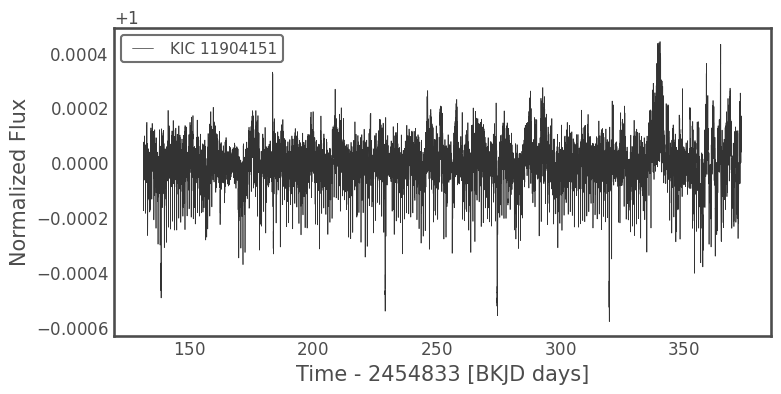

In [27]:
# Plot the cleaned curve now
figsize=(20, 4)
lc_filled.plot()
plt.show()

TAKEAWAY: The Preprocessed curve now shows high frequency dips more clearly.

`period` contains 331977 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


<Figure size 1200x600 with 0 Axes>

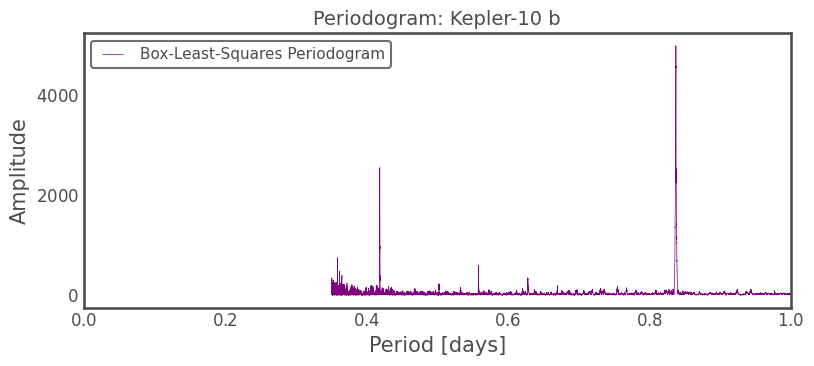

In [31]:
# Periodicity Analysis in the Frequency Domain
#lightkurve Box-Least-Squares periodogram
boxleastsquares_periodogram = lc_filled.to_periodogram(method="boxleastsquares")
plt.figure(figsize=(12, 6))
boxleastsquares_periodogram.plot(color="purple", label="Box-Least-Squares Periodogram")
plt.title(f"Periodogram: {target}", fontsize=14)
plt.xlabel("Period [days]")
plt.ylabel("Amplitude")
plt.xlim(0, 1)  # Focus on short periods typical for exoplanets
plt.tight_layout()
plt.show()

In [32]:
print(f"Box Least Squares Best Period: {boxleastsquares_periodogram.period_at_max_power}")
# This isolates the transit event!

Box Least Squares Best Period: 0.8374670264585736 d


**TAKEAWAY**: The lightcuve shows high frequency fluctuations at a period of 0.837 days, estimating the orbit of the Exoplanet(This value is confirmed by the literature available via NASA).

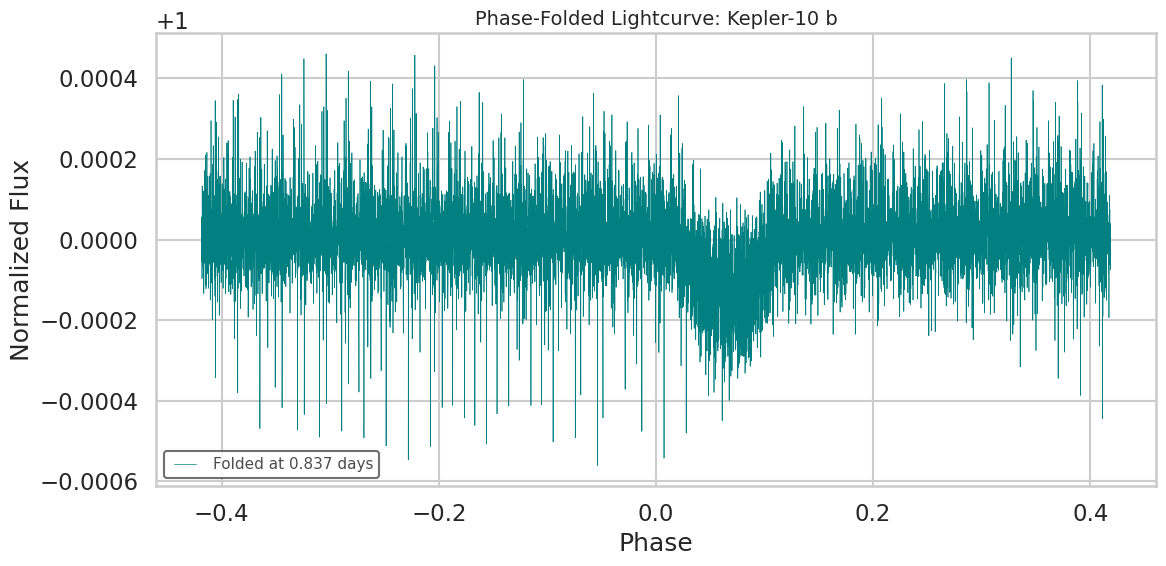

In [33]:
# Phase-Folded Lightcurve
# Visualization:
best_period = boxleastsquares_periodogram.period_at_max_power.value
#best_period = lombscargle_periodogram.period_at_max_power.value
folded_lc = lc_filled.fold(period=best_period, epoch_time=lc.time.value[0])
plt.figure(figsize=(12, 6))
folded_lc.plot(ax=plt.gca(), color="teal", label=f"Folded at {best_period:.3f} days")
plt.title(f"Phase-Folded Lightcurve: {target}", fontsize=14)
plt.xlabel("Phase")
plt.ylabel("Normalized Flux")
plt.tight_layout()
plt.show()
#plt.savefig(os.path.join(output_dir, "folded_lightcurve.png"))
#plt.close()


**TAKEAWAY**: The folded curve very clearly shows the **U-shaped dip in Flux** that is characteristing of the Exoplanet passing in front of the star.

**SUMMARY**: Each lightcurve selected for training and validation of any ML Model will first need to be de-trended and de-seasonalized, and irregularities in the time dimension will need to be handled.